In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool

In [2]:
def line(x, a, b):
    return a*x + b

In [3]:
def simulation(param):
    P1, P2 = param
    ecc1, ecc0, ecc2 = 0.003, 0.070, 0.016
    mu1, mu2 = 36e-6, 28e-6
    omega1, omega0, omega2 = -0.4, -0.86, 0
    P_0, lambda_0 = 0.05, 0

    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, omega=omega1)
    sim.add(m=mu2, P=P2, e=ecc2, omega=omega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, l=lambda_0, e=ecc0, omega=omega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    sim.init_megno()
    
    # calculate megno
    time = np.logspace(0,5,num=100)*P_0
    for T in time:
        sim.integrate(T, exact_finish_time=0)
        if sim.calculate_megno() >= 2.5:
            megno = np.zeros(200)
            sim_time = np.linspace(sim.t, 50*sim.t, num=200)
            for i, t in enumerate(sim_time):
                try:
                    sim.integrate(t, exact_finish_time=0)
                    m = sim.calculate_megno()
                    megno[i] = m
                    if m >= 50:
                        break
                except rebound.Collision:
                    break
            y = megno[megno != 0]
            x = sim_time[0:len(y)]
            plt.plot(x,y,"o") 
            (popt, pcov) = curve_fit(line, x, y, maxfev=90000)
            print(f'ly={1/popt[0]}')
            return
    return

#     time = np.logspace(2,5,num=100)
#     megno = np.zeros(200)
#     for i, T in enumerate(time):
#         try:
#             sim.integrate(T, exact_finish_time=0)
#             megno[i] = sim.calculate_megno()
#         except rebound.Collision:
#             break
#     y = megno[megno != 0]
#     x = time[0:len(y)]
#     plt.plot(x,y,"o")   

In [4]:
Ngrid_x = 100
Ngrid_y = 100
P_0 = 0.05

r10 = np.linspace(0.49,0.76,Ngrid_x)
r20 = np.linspace(1.3,2.04,Ngrid_y)
parameters = [[P_0*x, P_0*y] for x in r10 for y in r20]

ly=171.30613022291445


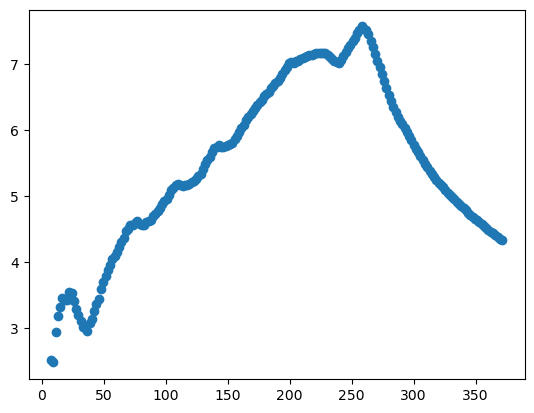

In [5]:
simulation(parameters[203])